# 4.9. Gráficos de esfuerzos y deformaciones

|Quién | Correo | Fecha | Qué hizo |
| ---  | ---    |---    | ---      |
|Michael Heredia Pérez      | <mherediap@unal.edu.co> | Octubre 22, 2022 | Conversión de código de MATLAB a Python|
|Diego Andrés Alvarez Marín | <daalvarez@unal.edu.co> | Octubre 28, 2023 | Graficando trayectorias de esfuerzos   |
|Diego Andrés Alvarez Marín | <daalvarez@unal.edu.co> | Febrero 16, 2024 | Mejorando los comentarios              |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable     # Sólo para el tamaño de la colorbar

Se harán varias gráficas con la misma configuración o similar, así que se crea una función para automatizar el proceso. La escala de colores utilizada (*colormap* en inglés) es ```bwr```.

In [2]:
from cmath import isclose

def plot_esf_def(variable, titulo, angulo = None):
    """
    Función para graficar los esfuerzos y las deformaciones. Usar:
    
    Variables:
        var    : es la variable que se quiere graficar.
        titulo : título del gráfico.
        angulo : (opcional) inclinaciones para los esfuerzos princiaples s1 y s2 y el esfuerzo cortante máximo tmax.
    """
    global x, y

    # Creo el lienzo.
    fig, ax = plt.subplots()
    
    # Coloreo el gráfico según la variable.
    im = ax.contourf(x, y, variable, 50, cmap = 'bwr', alpha=0.8)
    # Grafico las curvas de nivel.
    ax.contour(x, y, variable, 20, colors = "black", linewidths = 0.5, 
               linestyles = "solid")
    # Creo un axes adicional a la derecha en donde va la escala de colores.
    divider = make_axes_locatable(ax)
    # Creo la escala de colores.
    cax = divider.append_axes("right", size="5%", pad=0.05)
    # Configuro la escala para mostrar 5 intervalos/4 etiquetas.
    fig.colorbar(im, cax = cax).ax.locator_params(nbins = 5)
        
    # Para los esfuerzos principales se grafican las líneas que indiquen las
    # direcciones de los esfuerzos en cada nodo de la malla
    if angulo is not None:
       if type(angulo) is np.ndarray: 
           angulo = [ angulo ]
       for ang in angulo:
           ax.quiver(x, y, variable*np.cos(ang), variable*np.sin(ang),  
                headwidth=0, headlength=0, headaxislength=0, pivot="middle",
                linewidths = 2 
                )
    
    # Se especifican los ejes y el título, y se colocan los ejes iguales.
    ax.set_xlabel("$x$ [m]")
    ax.set_ylabel("$y$ [m]")
    ax.set_title(titulo, fontsize=15)
    ax.set_aspect('equal')
    ax.autoscale(tight=True)    
    plt.tight_layout()

    plt.show()

    """
    FALTA:
    Se quier que el blanco coincida siempre con el cero (0) sin afectar la 
    visualización.
    """

El problema que tenemos es una viga simplemente apoyada como se observa en la siguiente imagen:

<img src="https://raw.githubusercontent.com/michaelherediaperez/mecanica_de_solidos_un/main/figs/viga.png" width="600">

Definimos las dimensiones, cargas y propiedades constitutivas:

In [3]:
# Propiedades geométricas de la viga
c = 0.50    # [m] altura = 2c
L = 3.00    # [m] luz    = 2L

# Se calcula la inercia I = b*h^3/12, con b=1 y h=2c
I = (2*c**3)/3

# Carga aplicada
q = -10.0 # [kN/m]

# Propiedades del material
E  = 21e6         # [kPa] = 21 GPa módulo de Young.
nu = 0.23         # [-]            coeficiente de Poisson.
G  = E/(2*(1+nu)) # [kPa]          módulo de cortante.

Inicialmente, es necesario discretizar la geometría del sólido, esto lo hacemos mediante una malla o grilla:

In [4]:
# Se crea la grilla de puntos donde se harán los cálculos.
nnds_x = 50
nnds_y = 20
x, y = np.meshgrid(np.linspace(-L, L, nnds_x), np.linspace(-c, c, nnds_y))

La viga puede considerarse como un caso de tensión plana ($\sigma_z = \tau_{xz} = \tau_{yz} = 0$). Los esfuerzos al interior de la viga estarán caracterizados por las siguientes ecuaciones: 

\begin{align*}
\sigma_x(x,y,z)  &= -\frac{q}{2I} \left( x^2y - \frac{2}{3}y^3 + \frac{2}{5}c^2y - L^2y \right) \\
\sigma_y(x,y,z)  &= -\frac{q}{2I} \left( \frac{1}{3}y^3 - c^2y - \frac{2}{3}c^3 \right) \\
\sigma_z(x,y,z)  &= 0 \\
\tau_{xy}(x,y,z) &= -\frac{q}{2I}(c^2 - y^2)x \\
\tau_{xz}(x,y,z) &= 0 \\
\tau_{yz}(x,y,z) &= 0 
\end{align*}

In [5]:
# Se definen los esfuerzos (en tensión plana sz = txz = tyz = 0)
sx  = -(q/(2*I))*(x**2*y - 2*y**3/3 + 2*c**2*y/5 - L**2*y)
sy  = -(q/(2*I))*(y**3/3 - c**2*y - 2*c**3/3)
txy = -(q/(2*I))*(c**2 - y**2)*x

Como se puede ver, todas las ecuaciones son independientes de la variable $z$.

Se calculan las deformaciones al interior de la viga:

In [6]:
# Se calculan las deformaiones, eq (4.36)
ex  = (1/E)*(sx - nu*sy)
ey  = (1/E)*(sy - nu*sx)
ez  = -(nu/E)*(sx + sy)
gxy = txy/G

Y los esfuerzos y las direcciones principales y el esfuerzo cortante máximo:

In [7]:
# Se calculan los esfuerzos principales, los esfuerzos cortantes máximos y sus ángulos.
tmax = np.sqrt( ((sx - sy)/2)**2 + txy**2 )
s1 = (sx + sy)/2 + tmax
s2 = (sx + sy)/2 - tmax
t1 = np.arctan2(2*txy, sx-sy)/2     
t2 = t1 + np.pi/2                   # t1 + 90°

## Esfuerzos $\sigma_x$, $\sigma_y$ y $\tau_{xy}$

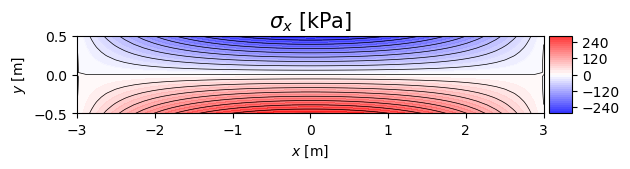

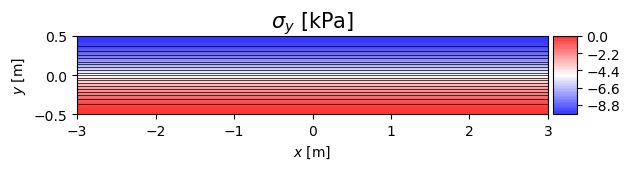

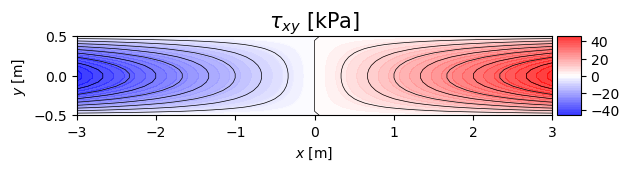

In [8]:
plot_esf_def(sx,  r"$\sigma_x$ [kPa]" )
plot_esf_def(sy,  r"$\sigma_y$ [kPa]" )
plot_esf_def(txy, r"$\tau_{xy}$ [kPa]")

## Deformaciones $\varepsilon_x$, $\varepsilon_y$, $\varepsilon_z$ y $\gamma_{xy}$

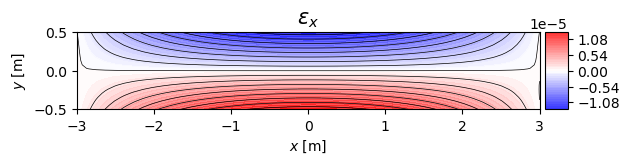

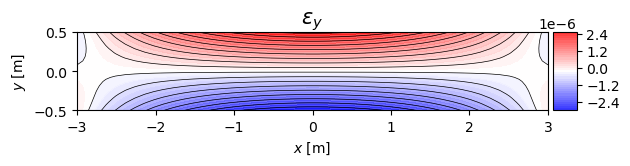

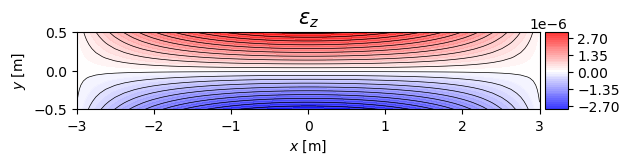

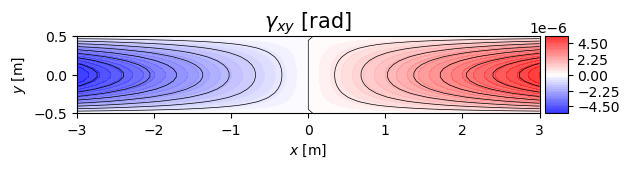

In [9]:
plot_esf_def(ex,  r"$\epsilon_x$"       )
plot_esf_def(ey,  r"$\epsilon_y$"       )
plot_esf_def(ez,  r"$\epsilon_z$"       )
plot_esf_def(gxy, r"$\gamma_{xy}$ [rad]")

## Esfuerzos principales $(\sigma_1)_{xy}$ y $(\sigma_2)_{xy}$

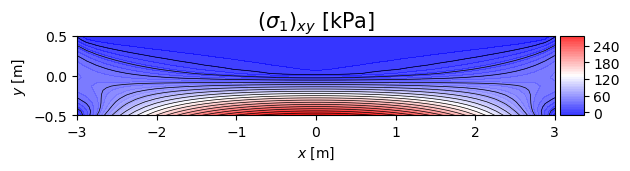

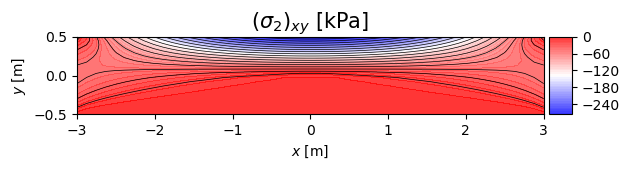

In [10]:
# SIN las inclinaciones
plot_esf_def(s1, r"$(\sigma_1)_{xy}$ [kPa]")
plot_esf_def(s2, r"$(\sigma_2)_{xy}$ [kPa]") 

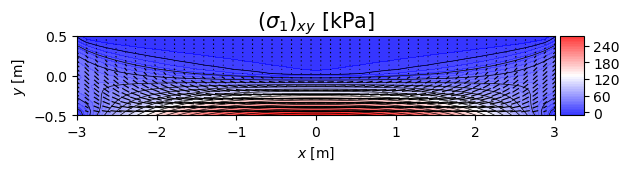

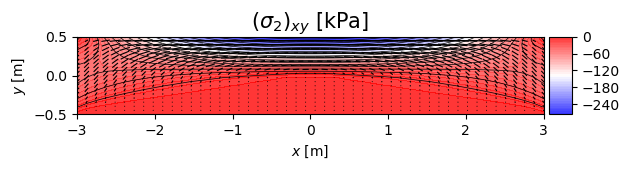

In [11]:
# CON las inclinaciones
plot_esf_def(s1, r"$(\sigma_1)_{xy}$ [kPa]", t1)
plot_esf_def(s2, r"$(\sigma_2)_{xy}$ [kPa]", t2) 

## Esfuerzo cortante máximo $(\tau_{\text{máx}})_{xy}$

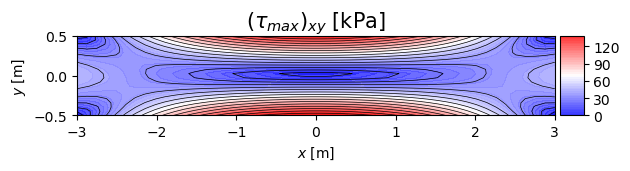

In [12]:
# SIN las inclinaciones
plot_esf_def(tmax, r"$(\tau_{max})_{xy}$ [kPa]")

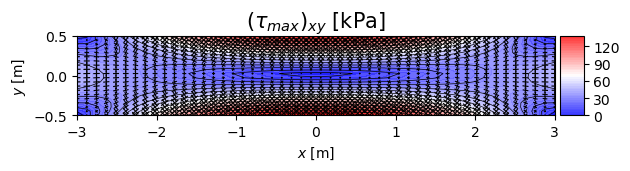

In [13]:
# CON las inclinaciones
plot_esf_def(tmax, r"$(\tau_{max})_{xy}$ [kPa]", [ t1-np.pi/4, t1+np.pi/4 ])

## Diagramas de fuerza cortante y momento flector

Las ecuaciones para la fuerza cortante $V(x)$ y el momento flector $M(x)$ son:

$$
\begin{align*}
V(x) &= -\iint \tau_{xy} (x,y,z) dydz = qx \\
M(x) &= -\iint y\sigma_x (x,y,z) dydz = -\frac{q}{2}(L^2 - x^2)
\end{align*}
$$

**Nota**: estas integrales fueron resueltas en este notebook: [04_09_04.ipynb](https://github.com/michaelherediaperez/mecanica_de_solidos_un/blob/main/codigos/cap_04/04_09_04.ipynb)

In [14]:
# Defino el dominio de evaluación.
xx = np.linspace(-L, L, nnds_x)

# Calculo la fuerza cortante y el momento flector.
V = q*xx
M = -q/2*(L**2 - xx**2)

Se construyen los diagramas

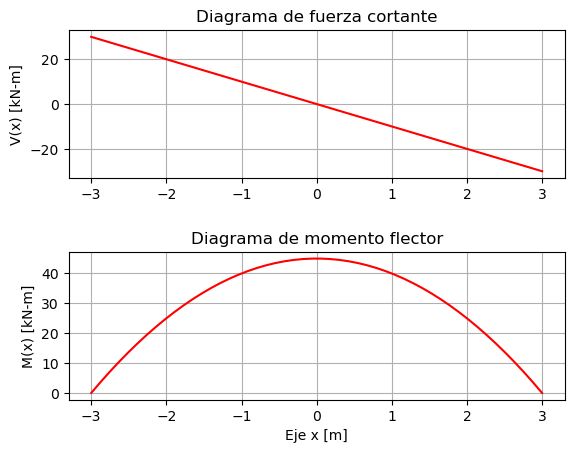

In [15]:
fig = plt.figure()
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(2):
    ax = fig.add_subplot(2, 1, i+1)
    ax.grid()
    if i == 0:
        ax.plot(xx, V, '-r')
        ax.set_ylabel("V(x) [kN-m]")
        ax.set_title("Diagrama de fuerza cortante")
    if i == 1:
        ax.plot(xx, M, '-r')
        ax.set_xlabel("Eje x [m]")
        ax.set_ylabel("M(x) [kN-m]")
        ax.set_title("Diagrama de momento flector")
plt.show()

## Se dibujan las trayectorias de esfuerzos

In [16]:
# Se definen los esfuerzos (en tensión plana sz = txz = tyz = 0)
sx  = lambda x,y : -(q/(2*I))*(x**2*y - 2*y**3/3 + 2*c**2*y/5 - L**2*y)
sy  = lambda x,y : -(q/(2*I))*(y**3/3 - c**2*y - 2*c**3/3)
txy = lambda x,y : -(q/(2*I))*(c**2 - y**2)*x

In [17]:
# Se plantean las ec. dif. que definen las líneas isostáticas
dydxf1 = lambda x,y : -(sx(x,y) - sy(x,y))/(2*txy(x,y)) + np.hypot(1, (sx(x,y) - sy(x,y))/(2*txy(x,y)))
dydxf2 = lambda x,y : -(sx(x,y) - sy(x,y))/(2*txy(x,y)) - np.hypot(1, (sx(x,y) - sy(x,y))/(2*txy(x,y)))

In [18]:
from scipy.integrate import solve_ivp

# Se resuelven las ecuaciones diferenciales, únicamente para la parte derecha
xini, xfin = 0.001, L   # x \in [x_inicial, x_final]
dominio = [xini, xfin]  # intervalo de solución de las ec. diferenciales
yini1   = np.linspace(-(c-0.001),     -0.001, 15)
yini2   = np.linspace( 0.001,     +(c-0.001), 15)

# LSODA, ya que la solución es "stiff"
sol1 = solve_ivp(dydxf1, dominio, yini1, method='LSODA'); x1,y1 = sol1.t,sol1.y.T
sol2 = solve_ivp(dydxf2, dominio, yini2, method='LSODA'); x2,y2 = sol2.t,sol2.y.T

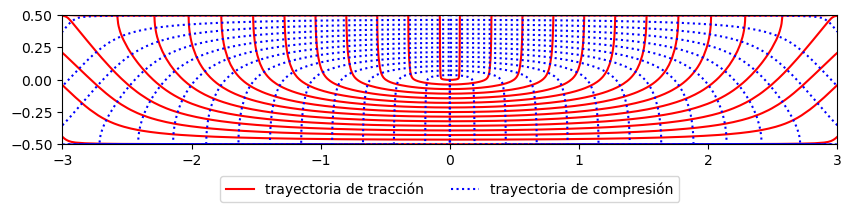

In [19]:
# Se dibujan las trayectorias de esfuerzos, teniendo en cuenta la simetría 
# geométrica de la viga y de sus cargas
fig, ax = plt.subplots(figsize=(10,2))
ax1 = ax.plot(x1,y1,'r-', -x1,y1,'r-', label='trayectoria de tracción')
ax2 = ax.plot(x2,y2,'b:', -x2,y2,'b:', label='trayectoria de compresión')
ax.set_aspect('equal')
ax.axis([-L, L, -c, c])       # ejes ajustados a [xmin, xmax, ymin, ymax]
plt.legend(handles=[ax1[0], ax2[1]], loc='lower center', bbox_to_anchor=(0.5, -0.5), ncols=2)
plt.show()